# Tests Realised for Thymio Project

## Import Libraries

In [44]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import tdmclient.notebook

# Add parent directory to path
import sys
import os

sys.path.append('..')
from scripts.vision import Vision
from utils import utils


## General Configuration

In [45]:
# Time step configuration
DT = 0.1  # s

# Webcam configuration
DEVICE_ID = 2

# World configuration
WORLD_WIDTH = 1060  # mm
WORLD_HEIGHT = 710 # mm

# Thymio configuration
THYMIO_WIDTH = 110  # mm
THYMIO_LENGTH = 110  # mm$
THYMIO_WHEEL_BASE = 90  # mm
THYMIO_WHEEL_RADIUS = 20  # mm

# Kidnapping configuration
KIDNAP_THRESHOLD = 40 # mm

## Connect to Thymio

In [46]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

@tdmclient.notebook.sync_var
def set_motor_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right

@tdmclient.notebook.sync_var
def get_motor_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed

@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0

Successfully connected to Thymio.


## Initialize Vision Module

In [47]:
vision = Vision(DEVICE_ID)

Vision initialized correctly.


## Speed Conversion Test

In [6]:
def calculate_speed(wheel_radius, num_rotations, time_seconds):
    circumference = 2 * wheel_radius * np.pi     # 2 * π * radius
    distance = circumference * num_rotations     # total distance traveled
    speed = distance / time_seconds              # speed in mm/s
    return speed

In [ ]:
# Set the speed of the robot
measuremend_time = 10
speed_settings = [50, 75, 100, 150, 200]
speed_to_coeffs = {speed: [] for speed in speed_settings}  # Dictionary to store coeffs for each speed
mean_coeffs = {}  # Dictionary to store mean coeff for each speed

print("Starting speed calibration measurements")
for speed_setting in speed_settings:
    for trial in range(3):
        # In your loop:
        clear_output(wait=True)  # This clears the previous output
        display(f"Trial {trial + 1} for speed setting: {speed_setting}")
        input("Press Enter to start counting rotations...")
        set_motor_speed(speed_setting, speed_setting)
        time.sleep(measuremend_time)
        motor_stop()
        rotations = float(input(f"Enter number of rotations counted in {measuremend_time} seconds: "))
    
        # Calculate actual speed in mm/s
        speed_mms = calculate_speed(THYMIO_WHEEL_RADIUS, rotations, measuremend_time)
        
        # Calculate conversion coefficient (setting/actual_speed)
        coeff = speed_setting / speed_mms
        speed_to_coeffs[speed_setting].append(coeff)

    # Calculate mean coefficient for this speed
    mean_coeffs[speed_setting] = np.mean(speed_to_coeffs[speed_setting])

# Print results
print("\nConversion coefficients for each speed:")
print("Speed Setting | Mean Coefficient | Individual Trials")
print("-------------|------------------|------------------")
for speed, coeffs in speed_to_coeffs.items():
    trials_str = ", ".join([f"{c:.4f}" for c in coeffs])
    print(f"{speed:12d} | {mean_coeffs[speed]:15.4f} | {trials_str}")

overall_mean = np.mean([coeff for coeffs in speed_to_coeffs.values() for coeff in coeffs])
print(f"\nOverall mean conversion coefficient: {overall_mean:.4f}")

'Trial 3 for speed setting: 200'


Conversion coefficients for each speed:
Speed Setting | Mean Coefficient | Individual Trials
-------------|------------------|------------------
          50 |          3.0462 | 3.0607, 3.1085, 2.9693
          75 |          2.8424 | 2.8421, 2.8020, 2.8832
         100 |          2.9012 | 2.9473, 2.8625, 2.8937
         150 |          2.9404 | 2.9842, 2.9256, 2.9114
         200 |          3.0030 | 3.0029, 2.9916, 3.0143

Overall mean conversion coefficient: 2.9466


In [ ]:
SPEED_TO_MM_S = 2.9466

## Camera Covariance Test (measurement error on x y theta)

In [14]:
# Initialize arrays to store positions and orientations
n_samples = 500
positions = np.zeros((n_samples, 2))  # For x,y positions
orientations = np.zeros(n_samples)    # For orientation values

try:
    vision.connect_webcam()
   # Collect data
    print("Collecting camera data...")
    vision.get_perspective_parameters(WORLD_WIDTH, WORLD_HEIGHT)
    found_thymio = False
    for i in tqdm(range(n_samples)):
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        if found_thymio:
            positions[i] = thymio_pos[:2] # Store x,y positions
            orientations[i] = thymio_pos[2] # Store orientation values
        else:
           # We want 500 samples, so if we don't find the Thymio, we need to go back one step
            i -= 1
        time.sleep(DT)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam connected correctly.
Find all four corners!
Got a valid perspective matrix and a defined roi!


  0%|          | 0/500 [00:00<?, ?it/s]

Webcam disconnected correctly.


In [15]:
# Calculate variances (covariances with themselves)
pos_mean = np.mean(positions, axis=0)
x_variance = np.var(positions[:, 0])
y_variance = np.var(positions[:, 1])
orientation_variance = np.var(orientations)

print("\nCovariance Results:")
print(f"X position variance: {x_variance:.8f}")
print(f"Y position variance: {y_variance:.8f}")
print(f"Orientation variance: {orientation_variance:.8f}")


Covariance Results:
X position variance: 0.00000000
Y position variance: 0.11758080
Orientation variance: 0.00002872


## Translation Velocity Covariance Test (odometry measurement error)


In [ ]:

all_samples = []
target_speeds = [100, 120, 140, 160, 180, 200]

for target_v in target_speeds:
    input(f"Press enter for speed {target_v}...")
    for i in range(5):
        input("Press enter for next trial...")
        print(f"Testing speed: {target_v}, trial {i + 1}")
        clear_output(wait=True)
        set_motor_speed(target_v, target_v)
        time.sleep(1)  # Stabilize
        
        samples = []
        for _ in range(50):
            left, right = get_motor_speed()
            v = (left + right) / 2
            samples.append(v)
            time.sleep(DT)
        
        all_samples.extend(samples)
        motor_stop()

# Organize and analyze data
samples_array = np.array(all_samples)
samples_per_trial = 50
trials_per_speed = 5
idx = 0

stats = {}
for speed in target_speeds:
    speed_trials = []
    for _ in range(trials_per_speed):
        trial = samples_array[idx:idx + samples_per_trial]
        speed_trials.append(trial)
        idx += samples_per_trial
        
    trial_means = [np.mean(trial) for trial in speed_trials]
    coefficients = [mean/speed for mean in trial_means]
    variances = [np.var(trial) for trial in speed_trials]
    
    stats[speed] = {
        'mean_velocity': np.mean(trial_means),
        'coefficients': coefficients, 
        'mean_coefficient': np.mean(coefficients),
        'variance': np.mean(variances)
    }

# Print results
print("\nSpeed | Mean Coef | Individual Coefficients")
print("------|-----------|----------------------")
for speed in target_speeds:
    coeffs = stats[speed]['coefficients']
    print(f"{speed:4d} | {stats[speed]['mean_coefficient']:.4f} | {', '.join([f'{c:.4f}' for c in coeffs])}")

overall_var = np.mean([s['variance'] for s in stats.values()])
overall_coef = np.mean([s['mean_coefficient'] for s in stats.values()])
print(f"\nOverall variance: {overall_var:.4f}")
print(f"Overall coefficient: {overall_coef:.4f}")



Speed | Mean Coef | Individual Coefficients
------|-----------|----------------------
 100 | 0.9827 | 0.9757, 0.9833, 0.9889, 0.9633, 1.0025
 120 | 0.9909 | 0.9853, 0.9936, 0.9914, 0.9902, 0.9938
 140 | 1.0003 | 0.9888, 0.9869, 0.9965, 1.0325, 0.9970
 160 | 0.9907 | 0.9922, 0.9971, 0.9886, 0.9836, 0.9922
 180 | 0.9935 | 0.9998, 0.9984, 0.9922, 0.9886, 0.9887
 200 | 0.9969 | 0.9864, 1.0024, 0.9992, 1.0030, 0.9936

Overall variance: 54.5216
Overall coefficient: 0.9925


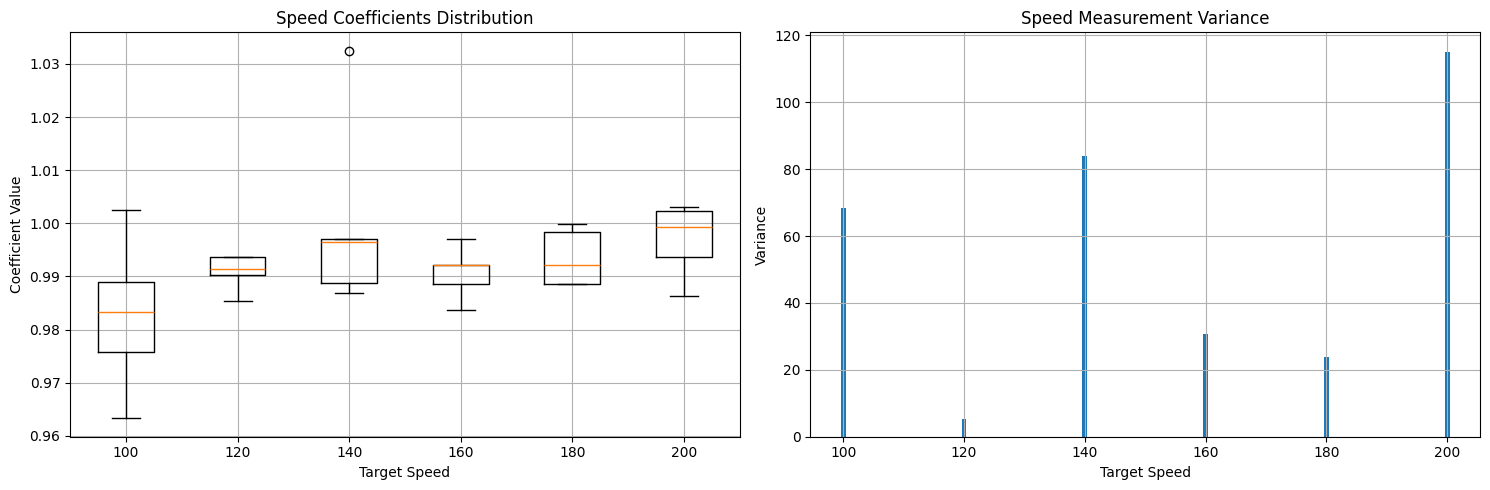

In [50]:
speeds = list(stats.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Coefficients distribution
coeffs = [stats[s]['coefficients'] for s in speeds]
ax1.boxplot(coeffs, tick_labels=speeds)
ax1.set_xlabel('Target Speed')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Speed Coefficients Distribution')
ax1.grid(True)

# Plot 2: Variances
variances = [stats[s]['variance'] for s in speeds]
ax2.bar(speeds, variances)
ax2.set_xlabel('Target Speed')
ax2.set_ylabel('Variance')
ax2.set_title('Speed Measurement Variance')
ax2.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_linear_speed.png', dpi=300, bbox_inches='tight')
plt.show()


## Angular Velocity Covariance Test

In [ ]:
all_samples = []
target_speeds = [100, 120, 140, 160, 180, 200]

for target_v in target_speeds:
   input(f"Press enter for speed {target_v}...")
   for i in range(5):
       input("Press enter for next trial...")
       print(f"Testing angular speed: {target_v}, trial {i + 1}")
       clear_output(wait=True)
       set_motor_speed(target_v, -target_v)  # Opposite speeds for rotation
       time.sleep(1)
       
       samples = []
       for _ in range(50):
           left, right = get_motor_speed()
           omega = (right - left)
           # diviser par wheel base????? 
           samples.append(omega)
           time.sleep(DT)
       
       all_samples.extend(samples)
       motor_stop()

# Analysis
samples_array = np.array(all_samples)
samples_per_trial = 50
trials_per_speed = 5
idx = 0

stats = {}
for speed in target_speeds:
   speed_trials = []
   for _ in range(trials_per_speed):
       trial = samples_array[idx:idx + samples_per_trial]
       speed_trials.append(trial)
       idx += samples_per_trial
       
   trial_means = [np.mean(trial) for trial in speed_trials]
   coefficients = [mean/(2*speed) for mean in trial_means]  # Normalize by expected angular speed
   variances = [np.var(trial) for trial in speed_trials]
   
   stats[speed] = {
       'mean_omega': np.mean(trial_means),
       'coefficients': coefficients, 
       'mean_coefficient': np.mean(coefficients),
       'variance': np.mean(variances)
   }

print("\nSpeed | Mean Coef | Individual Coefficients")
print("------|-----------|----------------------")
for speed in target_speeds:
   coeffs = stats[speed]['coefficients']
   print(f"{speed:4d} | {stats[speed]['mean_coefficient']:.4f} | {', '.join([f'{c:.4f}' for c in coeffs])}")

overall_var = np.mean([s['variance'] for s in stats.values()])
overall_coef = np.mean([s['mean_coefficient'] for s in stats.values()])
print(f"\nOverall angular variance: {overall_var:.4f}")
print(f"Overall angular coefficient: {overall_coef:.4f}")


Speed | Mean Coef | Individual Coefficients
------|-----------|----------------------
 100 | -0.9868 | -1.0010, -0.9707, -1.0023, -0.9756, -0.9844
 120 | -0.9925 | -0.9938, -0.9913, -0.9913, -0.9962, -0.9899
 140 | -0.9890 | -1.0009, -0.9883, -0.9803, -0.9771, -0.9983
 160 | -0.9941 | -0.9908, -0.9948, -0.9963, -0.9932, -0.9953
 180 | -0.9911 | -0.9912, -0.9844, -0.9982, -0.9940, -0.9876
 200 | -0.9921 | -0.9894, -0.9917, -0.9946, -0.9967, -0.9880

Overall angular variance: 170.8955
Overall angular coefficient: -0.9909


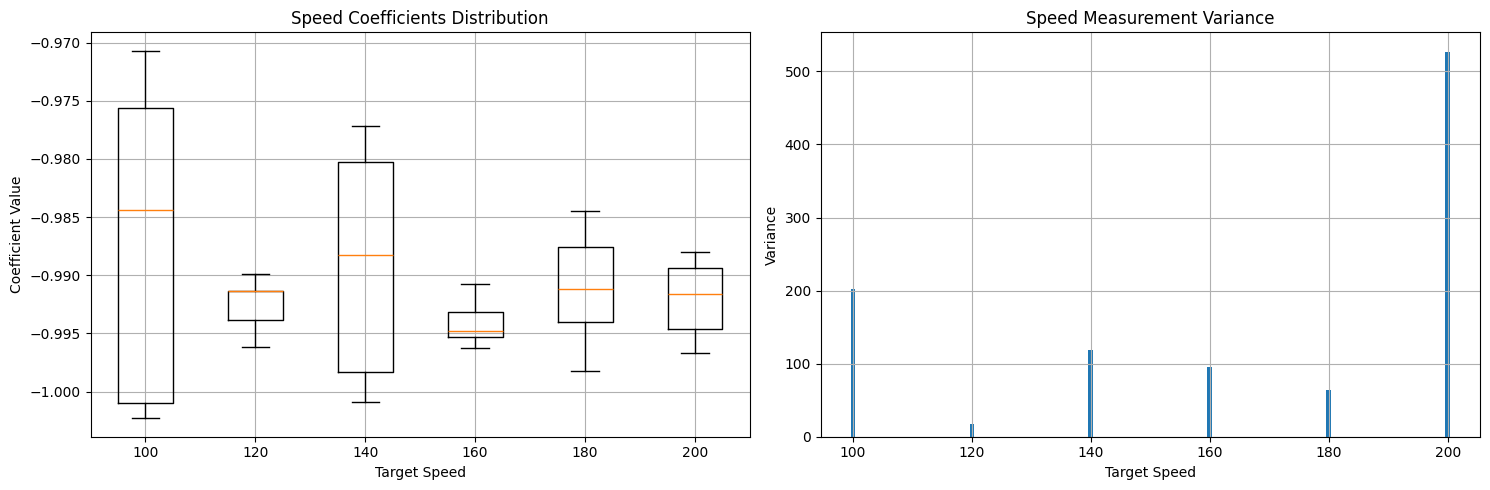

In [52]:
speeds = list(stats.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Coefficients distribution
coeffs = [stats[s]['coefficients'] for s in speeds]
ax1.boxplot(coeffs, tick_labels=speeds)
ax1.set_xlabel('Target Speed')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Speed Coefficients Distribution')
ax1.grid(True)

# Plot 2: Variances
variances = [stats[s]['variance'] for s in speeds]
ax2.bar(speeds, variances)
ax2.set_xlabel('Target Speed')
ax2.set_ylabel('Variance')
ax2.set_title('Speed Measurement Variance')
ax2.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_angular_speed.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
SPEED_TO_MM_S = 2.9466/2 # Tuned value

## X, Y Process Covariance Test AND LINEAR VELOCITY

In [ ]:
try:
    vision.connect_webcam()
    vision.get_perspective_parameters(WORLD_WIDTH, WORLD_HEIGHT)

    target_speeds = [100, 120, 140, 160, 180, 200]
    #all_variances = {speed: [] for speed in target_speeds}
    # MODIFICATION
    all_variances = {speed: {'pos': [], 'vel': []} for speed in target_speeds}
    
    for speed in target_speeds:
        input(f"Testing speed {speed}...")
        for trial in range(5):
            motor_stop()
            clear_output(wait=True)
            input(f"Trial {trial + 1}: Place robot at start, press enter...")
            print(f"Testing speed: {speed}, trial {trial + 1}")
            found_thymio = False
            vision.flush()
            while not found_thymio:
                _, process_frame = vision.get_frame()
                _, initial_pos, found_thymio = vision.get_thymio_position(process_frame)
            set_motor_speed(speed, speed)
            time.sleep(1)
            
            expected_positions = []
            actual_positions = []
            # MODIFICATION
            actual_velocities = []
            t = 0
            last_pos = initial_pos[:2]
            last_time = time.time()
            
            for _ in range(30):
                current_time = time.time()
                _, frame = vision.get_frame()
                _, pos, found = vision.get_thymio_position(frame)
                if found:
                    expected_x = initial_pos[0] + speed / SPEED_TO_MM_S * np.cos(pos[2]) * t
                    expected_y = initial_pos[1] + speed / SPEED_TO_MM_S * np.sin(pos[2]) * t
                    expected_positions.append([expected_x, expected_y])
                    actual_positions.append(pos[:2])

                    # Calculate actual velocity
                    dt = current_time - last_time
                    if dt > 0:
                        dx = pos[0] - last_pos[0]
                        dy = pos[1] - last_pos[1]
                        actual_v = np.sqrt(dx**2 + dy**2) / dt
                        actual_velocities.append(actual_v)
                    
                    last_pos = pos[:2]
                    last_time = current_time

                t += DT
                time.sleep(DT)
            
            motor_stop()
            diffs = np.array(actual_positions) - np.array(expected_positions)
            print(f"Differences - X: {np.mean(diffs[:, 0]):.4f}, Y: {np.mean(diffs[:, 1]):.4f}")
            
            position_var = np.var(diffs, axis=0)
            all_variances[speed].append(position_var)

            # MODIFICATION
            # Velocity variance calculation
            target_v = speed / SPEED_TO_MM_S  # Convert to mm/s
            velocity_diffs = np.array(actual_velocities) - target_v
            velocity_var = np.var(velocity_diffs)
            
            all_variances[speed]['pos'].append(position_var)
            all_variances[speed]['vel'].append(velocity_var)
            
except KeyboardInterrupt:
    pass
finally:
    motor_stop()
    vision.disconnect_webcam()
    # Print results
    print("\nSpeed | X Variance | Y Variance | V Variance")
    print("------|------------|------------|------------")
    for speed in target_speeds:
        mean_pos_var = np.mean(all_variances[speed]['pos'], axis=0)
        mean_vel_var = np.mean(all_variances[speed]['vel'])
        print(f"{speed:4d} | {mean_pos_var[0]:10.4f} | {mean_pos_var[1]:10.4f} | {mean_vel_var:10.4f}")
    
    overall_pos_var = np.mean([np.mean(vars['pos'], axis=0) for vars in all_variances.values()], axis=0)
    overall_vel_var = np.mean([np.mean(vars['vel']) for vars in all_variances.values()])
    print(f"\nOverall variance - X: {overall_pos_var[0]:.4f}, Y: {overall_pos_var[1]:.4f}, V: {overall_vel_var:.4f}")

Testing speed: 200, trial 5
Differences - X: 27.8026, Y: 0.1278
Webcam disconnected correctly.

Speed | X Variance | Y Variance
------|------------|------------
 100 |   118.8667 |     5.3802
 120 |   204.2880 |    40.4748
 140 |   203.9107 |    21.1964
 160 |   262.1593 |    19.3960
 180 |   246.7552 |    38.9504
 200 |   207.4335 |    10.1729

Overall variance - X: 207.2356, Y: 22.5951


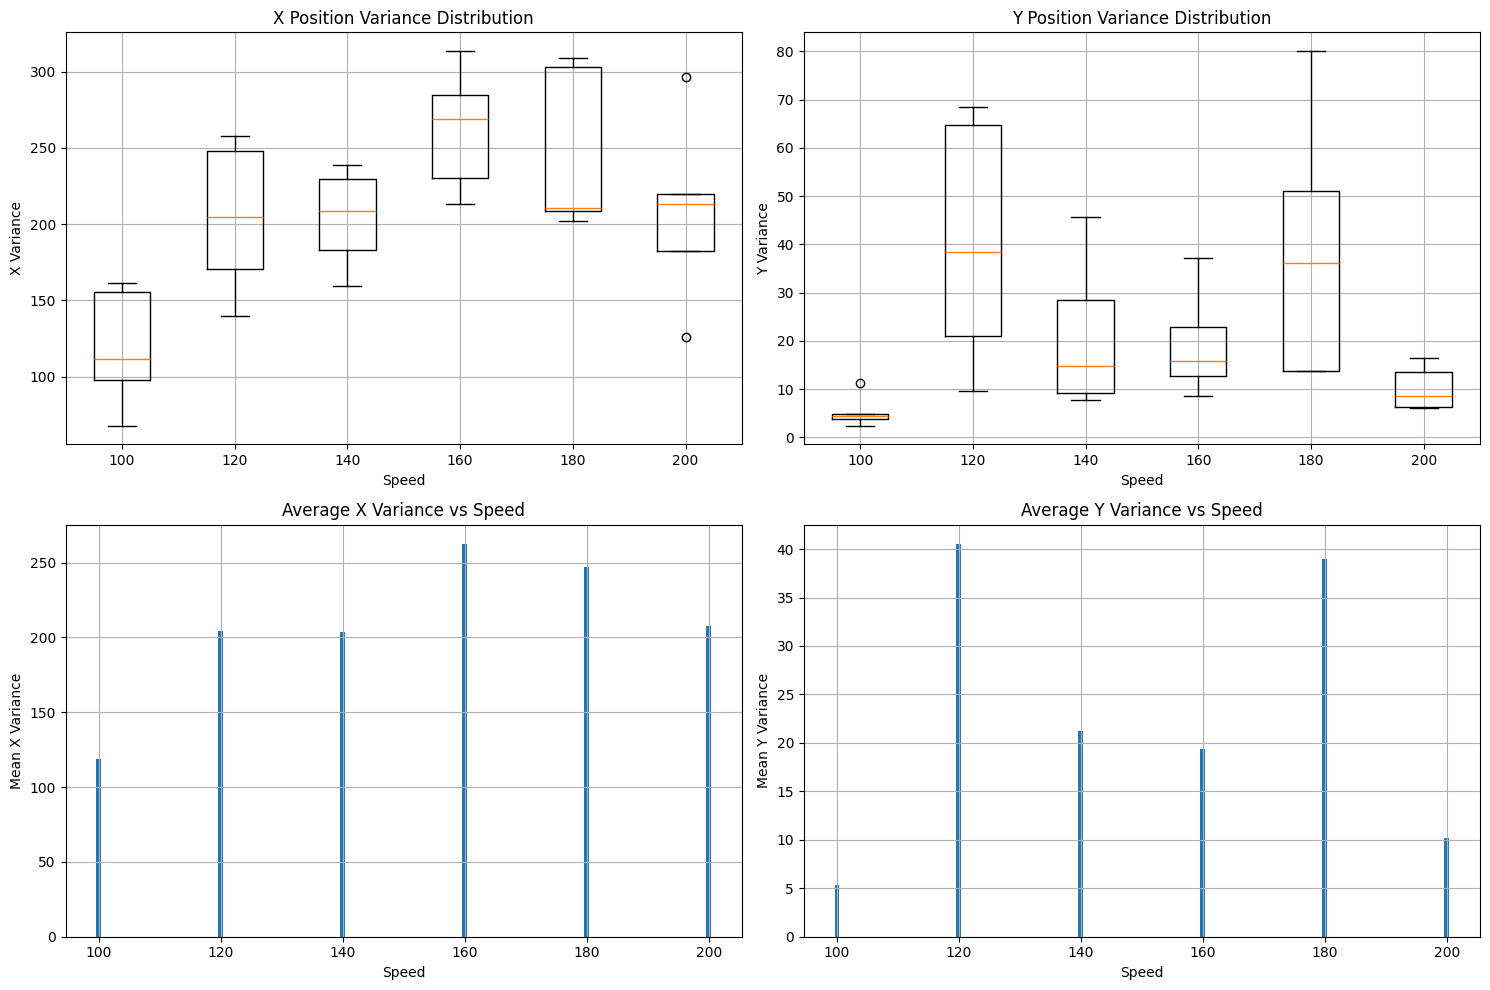

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
speeds = list(target_speeds)

# X variance distribution
box_data_x = [[trial[0] for trial in all_variances[s]] for s in speeds]
ax1.boxplot(box_data_x, tick_labels=speeds)
ax1.set_xlabel('Speed')
ax1.set_ylabel('X Variance')
ax1.set_title('X Position Variance Distribution')
ax1.grid(True)

# Y variance distribution
box_data_y = [[trial[1] for trial in all_variances[s]] for s in speeds]
ax2.boxplot(box_data_y, tick_labels=speeds)
ax2.set_xlabel('Speed')
ax2.set_ylabel('Y Variance')
ax2.set_title('Y Position Variance Distribution')
ax2.grid(True)

# Mean X variance
mean_x_vars = [np.mean([trial[0] for trial in all_variances[s]]) for s in speeds]
ax3.bar(speeds, mean_x_vars)
ax3.set_xlabel('Speed')
ax3.set_ylabel('Mean X Variance')
ax3.set_title('Average X Variance vs Speed')
ax3.grid(True)

# Mean Y variance
mean_y_vars = [np.mean([trial[1] for trial in all_variances[s]]) for s in speeds]
ax4.bar(speeds, mean_y_vars)
ax4.set_xlabel('Speed')
ax4.set_ylabel('Mean Y Variance')
ax4.set_title('Average Y Variance vs Speed')
ax4.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_position.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create a 2x3 subplot layout to accommodate velocity plots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
speeds = list(target_speeds)

# X variance distribution
box_data_x = [[trial[0] for trial in all_variances[s]['pos']] for s in speeds]
ax1.boxplot(box_data_x, tick_labels=speeds)
ax1.set_xlabel('Speed')
ax1.set_ylabel('X Variance')
ax1.set_title('X Position Variance Distribution')
ax1.grid(True)

# Y variance distribution
box_data_y = [[trial[1] for trial in all_variances[s]['pos']] for s in speeds]
ax2.boxplot(box_data_y, tick_labels=speeds)
ax2.set_xlabel('Speed')
ax2.set_ylabel('Y Variance')
ax2.set_title('Y Position Variance Distribution')
ax2.grid(True)

# V variance distribution
box_data_v = [[trial for trial in all_variances[s]['vel']] for s in speeds]
ax3.boxplot(box_data_v, tick_labels=speeds)
ax3.set_xlabel('Speed')
ax3.set_ylabel('Velocity Variance')
ax3.set_title('Velocity Variance Distribution')
ax3.grid(True)

# Mean X variance
mean_x_vars = [np.mean([trial[0] for trial in all_variances[s]['pos']]) for s in speeds]
ax4.bar(speeds, mean_x_vars)
ax4.set_xlabel('Speed')
ax4.set_ylabel('Mean X Variance')
ax4.set_title('Average X Variance vs Speed')
ax4.grid(True)

# Mean Y variance
mean_y_vars = [np.mean([trial[1] for trial in all_variances[s]['pos']]) for s in speeds]
ax5.bar(speeds, mean_y_vars)
ax5.set_xlabel('Speed')
ax5.set_ylabel('Mean Y Variance')
ax5.set_title('Average Y Variance vs Speed')
ax5.grid(True)

# Mean V variance
mean_v_vars = [np.mean(all_variances[s]['vel']) for s in speeds]
ax6.bar(speeds, mean_v_vars)
ax6.set_xlabel('Speed')
ax6.set_ylabel('Mean Velocity Variance')
ax6.set_title('Average Velocity Variance vs Speed')
ax6.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_all.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(box_data_v, tick_labels=speeds)
plt.xlabel('Speed')
plt.ylabel('Velocity Variance')
plt.title('Velocity Variance Distribution')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(speeds, mean_v_vars)
plt.xlabel('Speed')
plt.ylabel('Mean Velocity Variance')
plt.title('Average Velocity Variance vs Speed')
plt.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_velocity.png', dpi=300, bbox_inches='tight')
plt.show()

## Angle Process Covariance Test

In [ ]:
try:
    vision.connect_webcam()
    vision.get_perspective_parameters(WORLD_WIDTH, WORLD_HEIGHT)

    target_speeds = [100, 120, 140, 160, 180, 200]
    all_variances = {speed: {'angle': [], 'angular_vel': []} for speed in target_speeds}

    def angle_difference(a1, a2):
        diff = abs(a1 - a2)
        return min(diff, 2*np.pi - diff)
    
    def normalize_angle(angle):
        """Normalize angle to [-π, π]"""
        return ((angle + np.pi) % (2 * np.pi)) - np.pi

    for speed in target_speeds:
        input(f"Testing rotation speed {speed}...")
        left = speed
        right = -speed
        for trial in range(5):
            motor_stop()
            clear_output(wait=True)
            input(f"Trial {trial + 1}: Place robot, press enter...")
            print(f"Testing speed: {speed}, trial {trial + 1}")
            vision.flush()
            found_thymio = False
            while not found_thymio:
                _, process_frame = vision.get_frame()
                _, initial_pos, found_thymio = vision.get_thymio_position(process_frame)
            
            # Calculate target angular velocity
            target_w = (left - right) / (THYMIO_WHEEL_BASE * SPEED_TO_MM_S)  # rad/s
            set_motor_speed(left, right)
            time.sleep(1)
            
            expected_angles = []
            actual_angles = []
            actual_angular_velocities = []
            
            t = 0
            last_angle = initial_pos[2]
            last_time = time.time()
            
            for _ in range(30):
                current_time = time.time()
                _, frame = vision.get_frame()
                _, pos, found = vision.get_thymio_position(frame)
                
                if found:
                    # Expected angle calculation
                    expected_angle = initial_pos[2] + target_w * t
                    expected_angle = expected_angle % (2 * np.pi)
                    actual_angle = pos[2] % (2 * np.pi)
                    
                    expected_angles.append(expected_angle)
                    actual_angles.append(actual_angle)
                    
                    # Calculate actual angular velocity
                    dt = current_time - last_time
                    if dt > 0:
                        # Handle angle wrapping when calculating difference
                        angle_diff = normalize_angle(actual_angle - last_angle)
                        actual_w = angle_diff / dt
                        actual_angular_velocities.append(actual_w)
                    
                    last_angle = actual_angle
                    last_time = current_time
                
                t += DT
                time.sleep(DT)
    
            motor_stop()
            
            # Calculate angle variance
            angle_diffs = [angle_difference(actual, expected) 
                          for actual, expected in zip(actual_angles, expected_angles)]
            angle_var = np.var(angle_diffs)
            
            # Calculate angular velocity variance
            w_diffs = np.array(actual_angular_velocities) - target_w
            w_var = np.var(w_diffs)
            
            all_variances[speed]['angle'].append(angle_var)
            all_variances[speed]['angular_vel'].append(w_var)
            
            print(f"Mean angle difference: {np.mean(angle_diffs):.4f}")
            print(f"Mean angular velocity difference: {np.mean(w_diffs):.4f}")
            
except KeyboardInterrupt:
    pass
finally:
    motor_stop()
    vision.disconnect_webcam()
    print("\nSpeed | Angle Variance | Angular Velocity Variance")
    print("------|----------------|------------------------")
    for speed in target_speeds:
        mean_angle_var = np.mean(all_variances[speed]['angle'])
        mean_w_var = np.mean(all_variances[speed]['angular_vel'])
        print(f"{speed:4d} | {mean_angle_var:12.4f} | {mean_w_var:22.4f}")

    overall_angle_var = np.mean([np.mean(vars['angle']) for vars in all_variances.values()])
    overall_w_var = np.mean([np.mean(vars['angular_vel']) for vars in all_variances.values()])
    print(f"\nOverall angle variance: {overall_angle_var:.4f}")
    print(f"Overall angular velocity variance: {overall_w_var:.4f}")

Testing speed: 200, trial 5
Mean angle difference: 0.3567775807737642
Webcam disconnected correctly.

Speed | Angle Variance
------|---------------
 100 |        0.0171
 120 |        0.0274
 140 |        0.0135
 160 |        0.0242
 180 |        0.0259
 200 |        0.0120

Overall angle variance: 0.0200


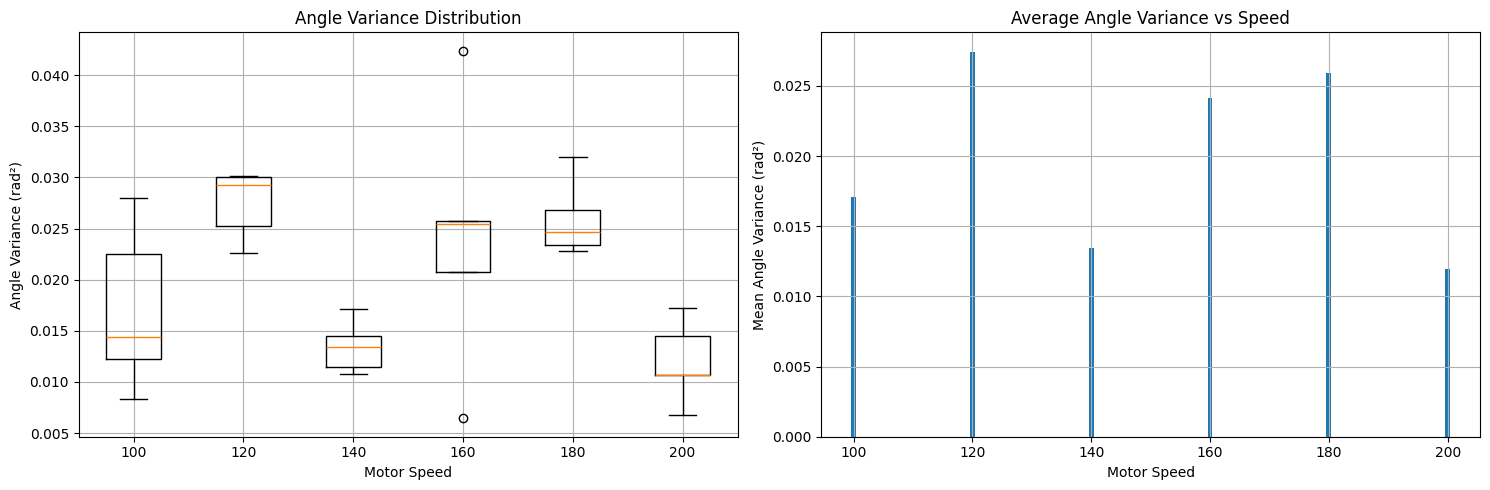

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

speeds = list(target_speeds)
box_data = [all_variances[s] for s in speeds]

ax1.boxplot(box_data, tick_labels=speeds)
ax1.set_xlabel('Motor Speed')
ax1.set_ylabel('Angle Variance (rad²)')
ax1.set_title('Angle Variance Distribution')
ax1.grid(True)

mean_vars = [np.mean(all_variances[s]) for s in speeds]
ax2.bar(speeds, mean_vars)
ax2.set_xlabel('Motor Speed')
ax2.set_ylabel('Mean Angle Variance (rad²)')
ax2.set_title('Average Angle Variance vs Speed')
ax2.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_angle.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
speeds = list(target_speeds)

# Angle variance distribution
box_data_angle = [all_variances[s]['angle'] for s in speeds]
ax1.boxplot(box_data_angle, tick_labels=speeds)
ax1.set_xlabel('Motor Speed')
ax1.set_ylabel('Angle Variance (rad²)')
ax1.set_title('Angle Variance Distribution')
ax1.grid(True)

# Mean angle variance
mean_angle_vars = [np.mean(all_variances[s]['angle']) for s in speeds]
ax2.bar(speeds, mean_angle_vars)
ax2.set_xlabel('Motor Speed')
ax2.set_ylabel('Mean Angle Variance (rad²)')
ax2.set_title('Average Angle Variance vs Speed')
ax2.grid(True)

# Angular velocity variance distribution
box_data_w = [all_variances[s]['angular_vel'] for s in speeds]
ax3.boxplot(box_data_w, tick_labels=speeds)
ax3.set_xlabel('Motor Speed')
ax3.set_ylabel('Angular Velocity Variance (rad²/s²)')
ax3.set_title('Angular Velocity Variance Distribution')
ax3.grid(True)

# Mean angular velocity variance
mean_w_vars = [np.mean(all_variances[s]['angular_vel']) for s in speeds]
ax4.bar(speeds, mean_w_vars)
ax4.set_xlabel('Motor Speed')
ax4.set_ylabel('Mean Angular Velocity Variance (rad²/s²)')
ax4.set_title('Average Angular Velocity Variance vs Speed')
ax4.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_angle_and_omega.png', dpi=300, bbox_inches='tight')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Angular velocity plots
ax1.boxplot(box_data_w, tick_labels=speeds)
ax1.set_xlabel('Motor Speed')
ax1.set_ylabel('Angular Velocity Variance (rad²/s²)')
ax1.set_title('Angular Velocity Variance Distribution')
ax1.grid(True)

ax2.bar(speeds, mean_w_vars)
ax2.set_xlabel('Motor Speed')
ax2.set_ylabel('Mean Angular Velocity Variance (rad²/s²)')
ax2.set_title('Average Angular Velocity Variance vs Speed')
ax2.grid(True)

plt.tight_layout()
plt.savefig('../img/covariance/process_variance_omega.png', dpi=300, bbox_inches='tight')
plt.show()